# Event-based analysis

Download data from https://gracedb.ligo.org/superevents/S190521g/ database

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
# Specify model of dynamical cluster. Available configurations include:
#----------------------------------------------------------------------
# max spin = 0.0, max mass = 9.0, r = 1.0
# max spin = 0.2, max mass = 5.3, r = 1.0
# max spin = 0.2, max mass = 6.0, r = 1.0
# max spin = 0.2, max mass = 9.0, r = 0.5
# max spin = 0.2, max mass = 9.0, r = 1.0
# max spin = 0.2, max mass = 9.0, r = 2.0
# max spin = 0.5, max mass = 9.0, r = 1.0
#----------------------------------------------------------------------

maxspin = 0.5
maxmass = 9.0
r = 1.0
model_name = '_s'+str(maxspin)+'_M'+str(maxmass)+'_r'+str(r)


# Choose the GW event to analyse. Downloaded data includes:

#------------------------------------------------------------------------

# GW190521 (most massive black holes)
# GW190412 (asymmetric masses, https://inspirehep.net/literature/1791693)
# GW191109 (90% credible interval for chi_eff<0)
# GW200225 (90% credible interval for chi_eff<0)

#------------------------------------------------------------------------
#"data/IGWN-GWTC2p1-v2-GW190412_053044_PEDataRelease_mixed_cosmo.h5"
#"data/IGWN-GWTC2p1-v2-GW190521_030229_PEDataRelease_mixed_cosmo.h5" 
#"data/IGWN-GWTC3p0-v1-GW191109_010717_PEDataRelease_mixed_cosmo.h5"
#"data/IGWN-GWTC3p0-v1-GW200225_060421_PEDataRelease_mixed_cosmo.h5"
#------------------------------------------------------------------------

event = 'GW200225'
GWdata = "data/IGWN-GWTC3p0-v1-GW200225_060421_PEDataRelease_mixed_cosmo.h5"

## Download the dataset

https://zenodo.org/record/6513631#.Y07HwC9Q3mE (GWTC-2)

https://zenodo.org/record/5546663#.Y1E8Iy9Q2Ak (GWTC-3)

In [3]:
import pesummary  # (Hoy & Ramond, 2021)
from pesummary.io import read
print(pesummary.__version__)

data = read(GWdata)

0.13.9


2022-11-01  15:10:15 PESummary WARNING : Unable to install 'pycbc'. You will not be able to use some of the inbuilt functions.
2022-11-01  15:10:17 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-11-01  15:10:17 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-11-01  15:10:17 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
/opt/miniconda3/envs/techstack/lib/python3.10/site-packages/pesummary/utils/dict.py:153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.samples = np.array(_samples)


In [4]:
samples_dict = data.samples_dict
posterior_samples = samples_dict['C01:IMRPhenomXPHM']

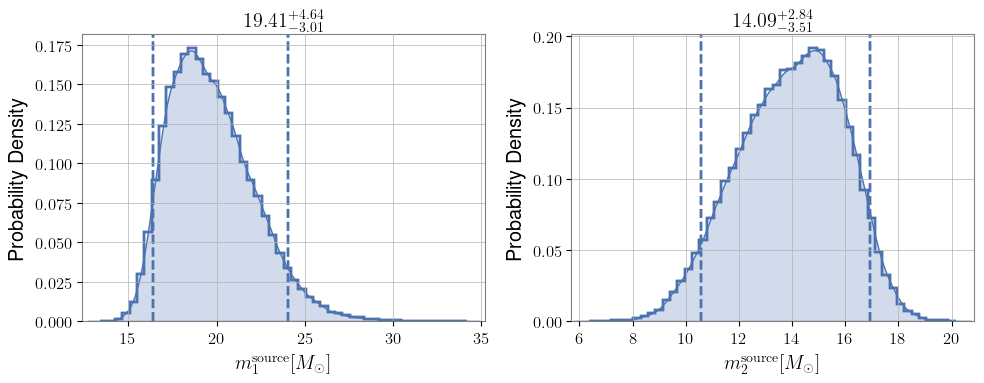

In [5]:
fig, ax =plt.subplots(1,2, figsize=(10,4))

_ = posterior_samples.plot('mass_1_source', type='hist', ax = ax[0])
_ = posterior_samples.plot('mass_1_source', type='hist',fig=fig, kde=True,  ax = ax[0])
_ = posterior_samples.plot('mass_2_source', type='hist', ax = ax[1])
_ = posterior_samples.plot('mass_2_source', type='hist',fig=fig, kde=True,  ax = ax[1])

In [6]:
# Extract the samples. Take a subset for simplicity

N_subset  = 24000
m1_samples   = posterior_samples['mass_1_source'][:N_subset]
m2_samples   = posterior_samples['mass_2_source'][:N_subset]
chi1_samples = posterior_samples['a_1'][:N_subset]
chi2_samples = posterior_samples['a_2'][:N_subset]

print('Length of samples:', len(m1_samples))

Length of samples: 24000


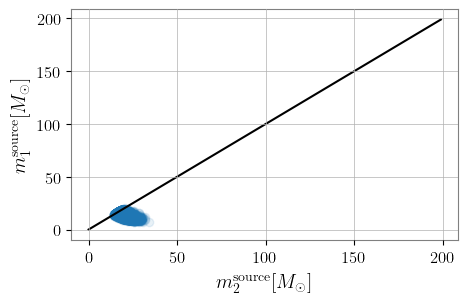

In [7]:
fig, ax =plt.subplots(figsize=(5,3))
             
plt.scatter(m1_samples, m2_samples, alpha =0.1)
plt.plot(np.arange(0,200), color='k')
plt.xlabel(r'$m^{\rm source}_2[M_\odot]$');
plt.ylabel(r'$m^{\rm source}_1[M_\odot]$');
#plt.xlim([60,180])

## Predicting the BHs' generations and the binary formation

In [8]:
def predict(model, input_):
    
    """
    Function to predict generations & formation scenario 
    
    Input:
    
    - model : trained model.
    - input : quartet of (m1,m2,chi1,chi2) for the BH generation 
              and (Mcl,zcl, m1,m2, chi1,chi2) for the binary formation.
    """
    
    final_pred = model.predict(pd.DataFrame([input_]))

    return final_pred[0]

In [9]:
# load the trained models from disk.

model_gen = pickle.load(open('models/RFclassifier_model' + model_name +'_gen.sav', 'rb'))
model_form = pickle.load(open('models/RFclassifier_model'+ model_name +'_form.sav', 'rb'))

In [10]:
predictions_gen = []

for (m1,m2,chi1,chi2) in zip(m1_samples, m2_samples, chi1_samples, chi2_samples):
    
    predictions_gen.append(predict(model_gen, [m1,m2,chi1,chi2]))

In [11]:
df_gen = pd.DataFrame(predictions_gen, columns = ['y_pred'])


p_1g1g = len(df_gen[df_gen['y_pred']==1])/len(df_gen)
p_1g2g = len(df_gen[df_gen['y_pred']==2])/len(df_gen)
p_2g2g = len(df_gen[df_gen['y_pred']==3])/len(df_gen)

print('Percentage of predictions with 1g+1g configuration:', p_1g1g)
print('Percentage of predictions with 1g+2g configuration:', p_1g2g)
print('Percentage of predictions with 2g+2g configuration:', p_2g2g)

print('total probability=', p_1g1g + p_1g2g + p_2g2g)

Percentage of predictions with 1g+1g configuration: 0.20775
Percentage of predictions with 1g+2g configuration: 0.5314583333333334
Percentage of predictions with 2g+2g configuration: 0.26079166666666664
total probability= 1.0


### Predicting formation scenarios

In [12]:
predictions_form = []

Mcl_range = [1e4, 3e4, 1e5,1e6, 1e7]        # Range of cluster masses to average through.
zcl_form_range = [.5, 1.0, 1.5, 2.0, 3.0]   # Range of redshift clusters

for (Mcl_0, zcl_form) in zip(Mcl_range, zcl_form_range):
    
    for (m1,m2,chi1,chi2) in zip(m1_samples, m2_samples, chi1_samples, chi2_samples):
    
        preds = predict(model_form, [Mcl_0,zcl_form, m1,m2,chi1,chi2])
        predictions_form.append([Mcl_0, zcl_form, preds])
    
df_form = pd.DataFrame(predictions_form, columns = ['Mcl_0', 'zcl_form', 'channel'])

In [13]:
print('Channel 1:', len(df_form[df_form['channel']==1]))
print('Channel 2:', len(df_form[df_form['channel']==2]))
print('Channel 3:', len(df_form[df_form['channel']==3]))
print('Channel 4:', len(df_form[df_form['channel']==4]))

Channel 1: 2958
Channel 2: 52116
Channel 3: 51197
Channel 4: 69


In [14]:
# Saving the results for posterity

all_results = {'p_1g1g': p_1g1g, 'p_1g2g': p_1g2g, 'p_2g2g': p_2g2g, 
               'channel_1': len(df_form[df_form['channel']==1]), 
               'channel_2': len(df_form[df_form['channel']==2]), 
               'channel_3': len(df_form[df_form['channel']==3]),
               'channel_4': len(df_form[df_form['channel']==4])}
               
with open('results/'+event+'/results_'+event+'_'+model_name+'.pickle', 'wb') as handle:
    pickle.dump(all_results, handle, protocol=pickle.HIGHEST_PROTOCOL)